In [299]:
import pandas as pd
import seaborn as sns
import numpy as np
import math

#to apply normalization and standarization
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_selector as selector

#encoding categorical variables 
from sklearn.preprocessing import OneHotEncoder

#to build and validate a KNN model
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

#visualizations
from plotnine import ggplot, aes, geom_density, geom_line, geom_point, ggtitle
import matplotlib.pyplot as plt

In [300]:
df = pd.read_csv('df_cleaned.csv')

In [302]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10462 entries, 0 to 10461
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   airline           10462 non-null  object
 1   embarked          10462 non-null  object
 2   destination       10462 non-null  object
 3   Route             10462 non-null  object
 4   stops             10462 non-null  object
 5   journey_year      10462 non-null  int64 
 6   journey_month     10462 non-null  int64 
 7   journey_day       10462 non-null  int64 
 8   weekday           10462 non-null  int64 
 9   dep_hour          10462 non-null  int64 
 10  dep_min           10462 non-null  int64 
 11  departure_period  10462 non-null  object
 12  Arrival_hour      10462 non-null  int64 
 13  Arrival_min       10462 non-null  int64 
 14  arrival_period    10462 non-null  object
 15  Arrived_next_day  10462 non-null  bool  
 16  duration_hours    10462 non-null  int64 
 17  duration_min

In [303]:
df.head()

,airline,embarked,destination,Route,stops,journey_year,journey_month,journey_day,weekday,dep_hour,...,departure_period,Arrival_hour,Arrival_min,arrival_period,Arrived_next_day,duration_hours,duration_mins,Duration_in_mins,price,additional_info
0,IndiGo,Banglore,New Delhi,BLR → DEL,non-stop,2019,3,24,6,22,...,night,1,10,late night,True,2,50,170,3898,No info
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,2 stops,2019,5,1,2,5,...,early morning,13,15,After noon,False,7,25,445,7663,No info
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,2 stops,2019,6,9,6,9,...,morning,4,25,late night,True,19,0,1140,13883,No info
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,1 stop,2019,5,12,6,18,...,evening,23,30,night,False,5,25,325,6219,No info
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,1 stop,2019,3,1,4,16,...,After noon,21,35,night,False,4,45,285,13303,No info


In [304]:
#drop Route
df.drop(['Route'], axis=1, inplace=True)

In [305]:
#drop additional_info
df.drop(['additional_info'], axis=1, inplace=True)

**split data**

In [306]:
train, test = train_test_split(df, train_size=0.7, random_state=123)

In [307]:
# separate features and target
X_train = train.drop("price", axis=1)
y_train = train[["price"]]

In [308]:
print(X_train.shape)
print(y_train.shape)

(7323, 18)
(7323, 1)


/tmp/ipykernel_389/3722340655.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_389/3722340655.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


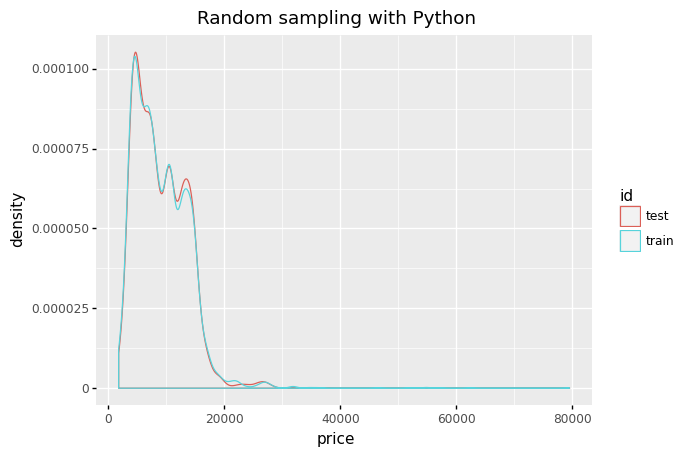

<ggplot: (8776969482165)>

In [309]:
#display the distribution of our split
train['id'] = 'train'
test['id'] = 'test'

(ggplot(pd.concat([train, test]), aes('price', color='id'))
 + geom_density()
 + ggtitle("Random sampling with Python"))

**Target engineering**

In [310]:
y_train.describe()

,price
count,7323.000000
mean,9039.892257
std,4737.526457
min,1760.000000
25%,5225.000000
50%,8267.000000
75%,12296.000000
max,79513.000000


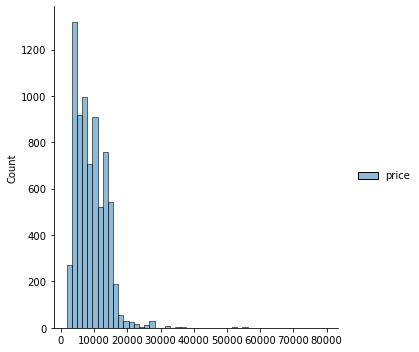

In [311]:
#explore distribution of target
target_dist= sns.displot(y_train, bins=50)
plt.show()

**Normalize target**

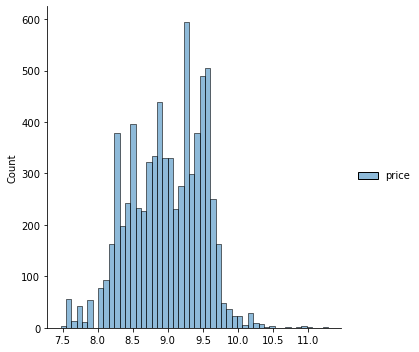

In [312]:
y_train = np.log(y_train)
sns.displot(y_train, bins= 50)

**Standarize target**

In [313]:
scaler = StandardScaler()
y_train=scaler.fit_transform(y_train)

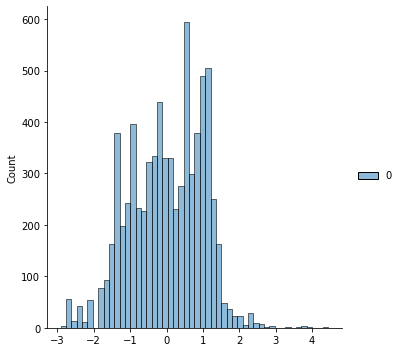

In [314]:
#we can see the target is now standarized
sns.displot(y_train, bins=50)
plt.show()

In [315]:
y_train.dtype

dtype('float64')

In [316]:
#check the new parameters
print(y_train.mean())
print(y_train.max())
print(y_train.min())

-1.0876941237021335e-15
4.441183825943805
-2.9063763517299024


**Fature engineering and selection**

----------------
based on EDA, we have 8 important features. we're going to use PCA to select the most important features and also toreduce the dimensionality. our features also showed multicollinearity. 

**Standarize features to apply feature importance**

**Standarize features**

In [317]:
#encoding ['stops'] separately because it requires a different type of encoding (ordinal encoding)
X_train['stops'].replace({'non-stop':0, '1 stop': 1, '2 stops': 2, '3 stops':3, '4 stops':4}, inplace=True)


In [318]:
X_train['stops'].value_counts()

1    3950
0    2428
2     917
3      27
4       1
Name: stops, dtype: int64

In [319]:
#create a df with object dtype features in preparation for encoding,  to avoid including the timedate dtypes in the encoding pipeline later
X_train_encoded = X_train[['airline', 'destination', 'embarked', 'departure_period', 'arrival_period']]

In [320]:
X_train_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7323 entries, 9681 to 3582
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   airline           7323 non-null   object
 1   destination       7323 non-null   object
 2   embarked          7323 non-null   object
 3   departure_period  7323 non-null   object
 4   arrival_period    7323 non-null   object
dtypes: object(5)
memory usage: 343.3+ KB


In [321]:
#now standarize all non-time features and on-hot encode the other categorical features
preprocessor = ColumnTransformer(
  remainder="passthrough",
  transformers=[
    ("scale", StandardScaler(), selector(dtype_include="number")),
    ("one-hot", OneHotEncoder(), selector(dtype_include="object"))
  ])

In [322]:
#apply the pipeline above to the x_train_encoded df
X_train_encoded = preprocessor.fit_transform(X_train)

In [323]:
X_train_encoded

array([[ 0.30162269,  0.        , -0.59542806, ...,  0.        ,
         0.        ,  0.        ],
       [-1.21748525,  0.        , -1.4525776 , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.30162269,  0.        ,  0.26172148, ...,  1.        ,
         0.        ,  1.        ],
       ...,
       [ 0.30162269,  0.        , -0.59542806, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.30162269,  0.        ,  1.11887102, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.30162269,  0.        ,  1.11887102, ...,  0.        ,
         0.        ,  0.        ]])

In [324]:
X_train_encoded.shape

(7323, 48)

In [325]:
print(X_train_encoded.min())
print(X_train_encoded.mean())
print(X_train_encoded.max())

-2.1638370341917015
0.11230313168555695
4.858946495412656


**Feature importance** 

**Build and fit a KNN model**

In [326]:
knn = KNeighborsRegressor(n_neighbors=10)

In [327]:
m1 = knn.fit(X_train_encoded,y_train)

In [328]:
m1.predict(X_train_encoded)

array([[-0.60818718],
       [-1.0936124 ],
       [ 0.68396505],
       ...,
       [ 0.61095562],
       [-0.19252559],
       [ 0.21542684]])

In [329]:
#calculate MSE
pred = m1.predict(X_train_encoded)
mse = mean_squared_error(y_train, pred)
mse

0.15671772010713658

In [330]:
#calculate RMSE
math.sqrt(mse)

0.3958758897775117

**Validation using kFold cross validation**

In [331]:
# define loss function
loss = 'neg_root_mean_squared_error'

# create 10 fold CV object
cv = KFold(n_splits=10, random_state=123, shuffle=True)

# fit model with 10-fold CV
scores = cross_val_score(m1, X_train_encoded, y_train, cv=cv, scoring=loss)
scores

array([-0.46936901, -0.4431172 , -0.4512485 , -0.42214701, -0.42335253,
       -0.44434044, -0.41739767, -0.44446223, -0.48600141, -0.47895029])

In [332]:
#averga eRMSE across 10 folds
scores.mean()

-0.4480386283131482

In [334]:
#RMSE vlaues across 50 folds
rfk = RepeatedKFold(n_splits=10, n_repeats=5, random_state=123)
rfk_scores = cross_val_score(m1, X_train_encoded, y_train, cv=rfk, scoring=loss)
rfk_scores

array([-0.46936901, -0.4431172 , -0.4512485 , -0.42214701, -0.42335253,
       -0.44434044, -0.41739767, -0.44446223, -0.48600141, -0.47895029,
       -0.46671388, -0.45343993, -0.49681846, -0.43709603, -0.42334556,
       -0.42402566, -0.44986362, -0.42483002, -0.44179176, -0.47500508,
       -0.4572271 , -0.40156047, -0.48850597, -0.4536705 , -0.4312838 ,
       -0.48783836, -0.45357311, -0.447438  , -0.44050034, -0.44445113,
       -0.44869166, -0.48388125, -0.41778025, -0.46827689, -0.39879394,
       -0.43911697, -0.43397925, -0.47734172, -0.43684485, -0.48823683,
       -0.43650656, -0.43064591, -0.47682142, -0.41049786, -0.44462167,
       -0.45891936, -0.46501422, -0.44661462, -0.45102359, -0.47039821])

In [335]:
#average RMSE across 50 folds
rfk_scores.mean()

-0.449267441994508

**Hyperparameter tuning**

In [336]:
#creating grid for GridSearch
hyper_grid = {'n_neighbors': range(2, 26)}

#tuning
grid_search = GridSearchCV(knn, hyper_grid, cv=cv, scoring=loss)
results = grid_search.fit(X_train_encoded, y_train)

#best model's cross validated RMSE
abs(results.best_score_)

0.4371081349979981

In [337]:
# Best model's k
results.best_estimator_.get_params().get('n_neighbors')

6

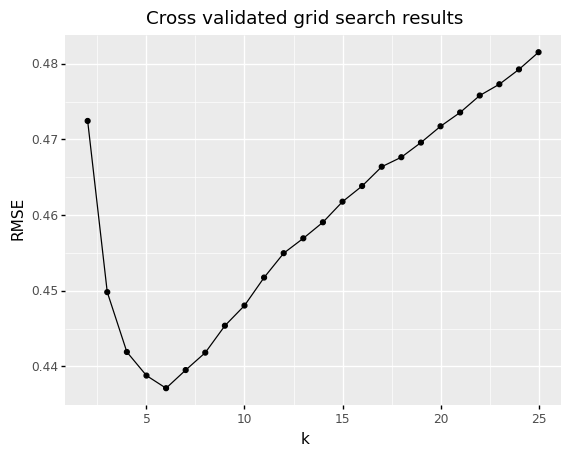

<ggplot: (8776967782160)>

In [338]:
# Plot all RMSE results (notice best RMSE is 0.43710 at K = 6)
all_rmse = pd.DataFrame({'k': range(2, 26), 
                         'RMSE': np.abs(results.cv_results_['mean_test_score'])})

(ggplot(all_rmse, aes(x='k', y='RMSE'))
 + geom_line()
 + geom_point()
 + ggtitle("Cross validated grid search results"))